In [ ]:
%pip install matplotlib librosa torch kagglehub
%pip install librosa --upgrade

In [3]:
import os
import glob
import librosa
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from tqdm import tqdm
import matplotlib.pyplot as plt
import re
import kagglehub
import os
import glob

In [ ]:
# Downloading dataset
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

print("Path to dataset files:", path)

In [5]:
print("music genres in the dataset:", list(os.listdir(f'{path}/Data/genres_original/')))
print("number of music genres:", len(list(os.listdir(f'{path}/Data/genres_original/'))))

music genres in the dataset: ['pop', 'metal', 'disco', 'blues', 'reggae', 'classical', 'rock', 'hiphop', 'country', 'jazz']
number of music genres: 10


In [6]:
# Define the directory path
directory = f'{path}/Data/genres_original/'
# Initialize a variable to store the minimum length
min_length = float('inf')
number_files = 0

# Iterate over all files in the directory
for genre in os.listdir(directory):
    genre_path = os.path.join(directory, genre)

    # Ensure it's a directory
    if os.path.isdir(genre_path):
        for filename in os.listdir(genre_path):
            if filename.endswith('.wav'):
                file_path = os.path.join(genre_path, filename)
                number_files += 1
                # Load the audio file using librosa
                y, sr = librosa.load(file_path)

                # Update the minimum length if needed
                min_length = min(min_length, len(y))

print(f"The minimum length of the music time series across all files is: {min_length}, it's corresponds to a minimum of {min_length/22050} seconds")
print("Number of files:", number_files)

The minimum length of the music time series across all files is: 660000, it's corresponds to a minimum of 29.931972789115648 seconds
Number of files: 999


In [7]:
# Define the directory path
directory = f'{path}/Data/genres_original/'
len_dataset = 0
dataset_filenames = []
# Iterate over all files in the directory
for genre in os.listdir(directory):
    genre_path = os.path.join(directory, genre)

    # Ensure it's a directory
    if os.path.isdir(genre_path):
        for filename in os.listdir(genre_path):
            if filename.endswith('.wav'):
                file_path = os.path.join(genre_path, filename)
                for i in range(min_length//1024):
                    dataset_filenames.append([file_path, i])
print(len(dataset_filenames))

643356


In [8]:
def extract_string(input_str):
    # Regular expression to capture the string between the first two slashes
    match = re.search(r'/([^/]+)/', input_str)
    if match:
        return match.group(1)
    else:
        return None

### Parameters and Configuration

In [9]:
AUDIO_DIR = f'{path}/Data/genres_original/'    # Directory containing audio files
SAMPLE_RATE = 22050
N_FFT = 1024
HOP_LENGTH = 512
N_MELS = 64     # Frequency bins for the Mel-spectrogram
DURATION = 10.0   # Duration of each audio clip in seconds (30s is the entire clip)
GENRES = ['blues','classical','country','disco','hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']  # Example classes
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps")

# ConvRBM Hyperparameters
VISIBLE_CHANNELS = 1  # Spectrogram is treated as a single "image" channel
HIDDEN_CHANNELS = 16  # Number of convolutional filters
KERNEL_SIZE = (8, 8)
LEARNING_RATE = 1e-3
CD_K = 1    # Contrastive divergence steps
EPOCHS = 1000
BATCH_SIZE = 64


In [10]:
class AudioDataset(Dataset):
    def __init__(self, audio_dir, genres, duration=10.0, n_mels=64):
        self.data = []
        self.labels = []
        self._load_audio_files(audio_dir, genres, duration, n_mels)

    def _load_audio_files(self, audio_dir, genres, duration, n_mels):
        for i, genre in enumerate(genres):
            genre_path = os.path.join(audio_dir, genre)
            for fname in glob.glob(os.path.join(genre_path, "*.wav")):
                # Load audio
                audio, sr = librosa.load(
                    fname, 
                    sr=SAMPLE_RATE, 
                    duration=duration)
                # print("audio length", len(audio))

                # Compute Mel-Spectrogram
                mel_spec = librosa.feature.melspectrogram(
                    y=audio, 
                    sr=SAMPLE_RATE, 
                    n_fft=N_FFT,
                    hop_length=HOP_LENGTH, 
                    n_mels=n_mels)
                # Convert to log scale for better dynamic range
                log_mel = librosa.power_to_db(mel_spec, ref=np.max)
                # Normalize
                log_mel -= log_mel.min()
                log_mel /= log_mel.max()
                
                # Append data and label
                self.data.append(log_mel)
                # print("appending data", log_mel.shape)
                self.labels.append(i)
                # print("appending label", i)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Convert data and labels to PyTorch tensors
        mel_tensor = torch.tensor(self.data[idx], dtype=torch.float32).unsqueeze(0) # Adding singe channel dimension since it is grayscale
        label_tensor = torch.tensor(self.labels[idx], dtype=torch.long)
        return mel_tensor, label_tensor

In [11]:
def split_dataset(audio_dir=AUDIO_DIR, genres=GENRES, n_mels=N_MELS, test_size=0.1, val_size=0.1, random_seed=14):
    # Create the full dataset
    dataset = AudioDataset(audio_dir, genres, n_mels=n_mels)
    print("dataset length", len(dataset))
    
    # Split indices for training, validation, and test sets
    total_size = len(dataset)
    indices = list(range(total_size))
    train_indices, test_indices = train_test_split(
        indices, test_size=test_size, random_state=random_seed)
    
    # Further split the training indices into training and validation
    train_indices, val_indices = train_test_split(
        train_indices, test_size=val_size / (1 - test_size), random_state=random_seed)
    
    train_subset = Subset(dataset, train_indices)
    val_subset = Subset(dataset, val_indices)
    test_subset = Subset(dataset, test_indices)
    
    return train_subset, val_subset, test_subset

def get_dataloaders(audio_dir, genres=GENRES, n_mels=64, batch_size=BATCH_SIZE, test_size=0.1, val_size=0.1, shuffle=True, random_seed=13):
    train_subset, val_subset, test_subset = split_dataset(
        audio_dir, genres, test_size=test_size, val_size=val_size, n_mels=n_mels, random_seed=random_seed)
    
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=shuffle)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader

In [12]:
train_loader_64, val_loader_64, test_loader_64 = get_dataloaders(
    AUDIO_DIR, 
    GENRES, 
    batch_size=BATCH_SIZE, 
    n_mels=N_MELS,
    shuffle=False)

dataset length 999


In [13]:
print("Number of training batches:", len(train_loader_64))
print("Number of validation batches:", len(val_loader_64))
print("Number of test batches:", len(test_loader_64))

Number of training batches: 13
Number of validation batches: 2
Number of test batches: 2


## ConvRBM

### ConvRBM model

In [49]:
class ConvRBM(nn.Module):
    def __init__(self, visible_channels, hidden_channels, kernel_size=KERNEL_SIZE, learning_rate=1e-3, cd_k=1, batch_size=BATCH_SIZE):
        super(ConvRBM, self).__init__()
        self.visible_channels = visible_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        self.cd_k = cd_k
        self.batch_size = batch_size

        # Weights & biases
        self.W = nn.Parameter(torch.randn(hidden_channels, visible_channels, kernel_size[0], kernel_size[1]) * 0.01)
        self.v_bias = nn.Parameter(torch.zeros(1))
        self.h_bias = nn.Parameter(torch.zeros(hidden_channels, 1, 1))  # per hidden channel bias

        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def sample_h(self, v):
        # Convolution to compute hidden probabilities
        # v: [batch, visible_channels, height, width]
        conv_v = nn.functional.conv2d(v, self.W, bias=None)
        # Adding hidden bias
        h_lin = conv_v + self.h_bias
        h_prob = torch.sigmoid(h_lin)
        h_sample = torch.bernoulli(h_prob)
        return h_prob, h_sample

    def sample_v(self, h):
        # Transposing convolution to reconstruct visible
        # h: [batch, hidden_channels, h_out, w_out]
        deconv_h = nn.functional.conv_transpose2d(h, self.W, bias=None)
        v_lin = deconv_h + self.v_bias
        v_prob = torch.sigmoid(v_lin)
        v_sample = torch.bernoulli(v_prob)
        return v_prob, v_sample

    def forward(self, v):
        # do a forward pass to get hidden probabilities
        h_prob, _ = self.sample_h(v)
        return h_prob

    # Contrastive Divergence - simplified version with Gibbs sampling
    def contrastive_divergence(self, v):
        # Positive phase
        h_prob, h_sample = self.sample_h(v)

        # Negative phase
        v_neg = v
        for _ in range(self.cd_k):
            v_prob_neg, v_sample_neg = self.sample_v(h_sample)
            h_prob_neg, h_sample_neg = self.sample_h(v_sample_neg)
            v_neg = v_sample_neg
            h_sample = h_sample_neg

        # Reconstruction loss
        recon_error = torch.mean((v - v_prob_neg) ** 2)

        if self.training:
            self.optimizer.zero_grad()
            recon_error.backward()
            self.optimizer.step()

        return recon_error.item()

    def transform(self, v, approach="flatten"):
        """
        Transforms the input tensor `v` by applying the ConvRBM transformation and global average pooling
        to output a feature vector of shape [batch_size, n_mels].
        """
        with torch.no_grad():
            h_prob, _ = self.sample_h(v)
            print("approach", approach)

            if approach == "global_average_pooling":
                pooled_h_prob = torch.mean(h_prob, dim=3)
                pooled_h_prob = torch.mean(pooled_h_prob, dim=2)


            elif approach == "max_pooling":
                pooled_h_prob = nn.functional.max_pool2d(h_prob, kernel_size=(2, 2), stride=(2, 2))
                

            elif approach == "global_max_pooling":
                pooled_h_prob = torch.max(h_prob, dim=3).values  # Max pooling along the time axis (dim=3)
                pooled_h_prob = torch.max(pooled_h_prob, dim=2).values  # Max pooling along the frequency axis (dim=2)

            elif approach == "avg_pool2d":
                pooled_h_prob = nn.functional.avg_pool2d(h_prob, kernel_size=(2, 2), stride=(2, 2))

            else:
                pooled_h_prob = h_prob.view(v.size(0), -1)


            print("pooled_h_prob", pooled_h_prob.shape)
            return pooled_h_prob.view(v.size(0), -1)

    def train_rbm(self, train_loader, val_loader, epochs=10, device='cpu', save_interval=50, save_dir='./model_weights'):
        """Train the RBM on input data using the provided dataloaders for training and testing."""

        train_losses = []
        val_losses = []

        train_size = len(train_loader.dataset)
        val_size = len(val_loader.dataset)

        print(f"Training set size: {train_size}, Validation set size: {val_size}")

        # Ensure the save directory exists
        os.makedirs(save_dir, exist_ok=True)

        for epoch in range(epochs):
            self.train()
            train_loss = 0.0

            with tqdm(train_loader, unit=" batches") as pbar:
                for batch_X, _ in pbar:
                    batch_X = batch_X.to(device)

                    loss = self.contrastive_divergence(batch_X)
                    train_loss += loss

            # Average training loss across all batches
            avg_train_loss = train_loss / len(train_loader)
            train_losses.append(avg_train_loss)

            # Validation phase
            self.eval()
            val_loss = 0.0

            with torch.no_grad():
                for batch_X, _ in val_loader:
                    batch_X = batch_X.to(device)

                    loss = self.contrastive_divergence(batch_X)
                    val_loss += loss

            avg_val_loss = val_loss / len(val_loader)
            val_losses.append(avg_val_loss)

            # Logging epoch summary
            print(f"Epoch [{epoch + 1}/{epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

            # Save model weights at intervals
            if (epoch + 1) % save_interval == 0:
                save_path = os.path.join(save_dir, f'rbm_epoch_{epoch + 1}.pth')
                torch.save(self.state_dict(), save_path)
                print(f"Model weights saved to {save_path}")

                # Plot training and validation loss
                plt.figure(figsize=(10, 6))
                plt.plot(range(epoch + 1), train_losses, label='Training Loss')
                plt.plot(range(epoch + 1), val_losses, label='Validation Loss')
                plt.xlabel('Epochs')
                plt.ylabel('Loss')
                plt.title('Training and Validation Loss Over Epochs')
                plt.legend()
                plt.grid(True)
                plt.show()
                # save the plot
                plt.savefig(f'{save_dir}/loss_plot_{epoch + 1}.png')

                # Plot training and validation loss in log scale
                plt.figure(figsize=(10, 6))
                plt.plot(range(epoch + 1), train_losses, label='Training Loss')
                plt.plot(range(epoch + 1), val_losses, label='Validation Loss')
                plt.yscale('log')
                plt.xlabel('Epochs')
                plt.ylabel('Loss')
                plt.title('Training and Validation Loss Over Epochs (Log Scale)')
                plt.legend()
                plt.grid(True)
                plt.show()
                


### Instantiating ConvRBM

In [50]:
conv_rbm_64 = ConvRBM(
    visible_channels=VISIBLE_CHANNELS,
    hidden_channels=HIDDEN_CHANNELS,
    kernel_size=KERNEL_SIZE,
    learning_rate=LEARNING_RATE,
    cd_k=CD_K,
    batch_size=BATCH_SIZE
).to(DEVICE)

### Training ConvRBM

In [ ]:
conv_rbm_64.train_rbm(
    train_loader_64, 
    val_loader_64,
    epochs=1000, 
    device=DEVICE,
    save_interval=3)

### Feature Extraction using ConvRBM

In [ ]:
# Load the saved model weights
conv_rbm_64.load_state_dict(torch.load('./model_weights/rbm_epoch_325.pth'))
conv_rbm_64.eval()

train_features = {}
test_features = {}

approaches = ["flatten", "global_average_pooling", "max_pooling", "global_max_pooling", "avg_pool2d"]

for approach in approaches:
    print(f"Processing features for approach: {approach}")
    train_batch = []
    test_batch = []

    with torch.no_grad():
        # Process training features
        for train_X, _ in train_loader_64:
            train_X = train_X.to(DEVICE)
            f = conv_rbm_64.transform(train_X, approach=approach)
            train_batch.append(f.cpu().numpy())

        train_features[approach] = np.concatenate(train_batch, axis=0)

        # Process testing features
        for test_X, _ in test_loader_64:
            test_X = test_X.to(DEVICE)
            f = conv_rbm_64.transform(test_X, approach=approach)
            test_batch.append(f.cpu().numpy())

        # Store all testing features as a single big list in the dictionary
        test_features[approach] = np.concatenate(test_batch, axis=0)

In [52]:
print("Train features shape:", len(train_features["flatten"]))

Train features shape: 799


### Classification

In [54]:
# Extract labels for the train and test datasets
train_labels = []
test_labels = []

for _, label in train_loader_64.dataset:
    train_labels.append(label)

for _, label in test_loader_64.dataset:
    test_labels.append(label)

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)


In [55]:
# random forest classifier

for approach in train_features.keys():
    dt_clf = RandomForestClassifier(max_depth=15, random_state=13)
    print(len(train_features[approach]))
    dt_clf.fit(train_features[approach], train_labels)

    test_predictions = dt_clf.predict(test_features[approach])

    accuracy = accuracy_score(test_labels, test_predictions)
    print(f"Decision Tree Classifier Accuracy using {approach} pooling: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(test_labels, test_predictions))

799
Decision Tree Classifier Accuracy using flatten pooling: 0.4600

Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.50      0.40         8
           1       0.36      1.00      0.53         5
           2       0.50      0.27      0.35        11
           3       0.20      0.17      0.18         6
           4       0.56      0.45      0.50        11
           5       0.88      0.50      0.64        14
           6       0.76      0.76      0.76        17
           7       0.29      0.67      0.40         6
           8       0.36      0.33      0.35        12
           9       0.00      0.00      0.00        10

    accuracy                           0.46       100
   macro avg       0.42      0.47      0.41       100
weighted avg       0.49      0.46      0.45       100

799
Decision Tree Classifier Accuracy using global_average_pooling pooling: 0.4100

Classification Report:
              precision    recall  f1-scor

In [ ]:
# Train an SVM model
for approach in approaches:
    print(f"Training SVM classifier using features extracted with {approach} pooling")
    # Initialize the SVM classifier
    
    svm_clf = SVC(kernel='rbf', C=1.0, decision_function_shape='ovr')  # Using RBF kernel; you can try others like 'linear' or 'poly'
    svm_clf.fit(train_features[approach], train_labels)

    # Predict on the test set
    y_pred = svm_clf.predict(test_features[approach])

    # Calculate accuracy
    acc = accuracy_score(test_labels, y_pred)

    print(f"Test Accuracy using {approach} pooling: {acc:.4f}")

t-SNE visualization

In [57]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd

def plot_tsne(features, labels):
    tsne = TSNE(n_components=2, random_state=13)
    tsne_features = tsne.fit_transform(features)

    tsne_df = pd.DataFrame(tsne_features, columns=['Component 1', 'Component 2'])
    tsne_df['Label'] = labels

    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=tsne_df, x='Component 1', y='Component 2', hue='Label', palette='viridis', alpha=0.6)
    plt.title('t-SNE Visualization of Audio Features')
    plt.show()


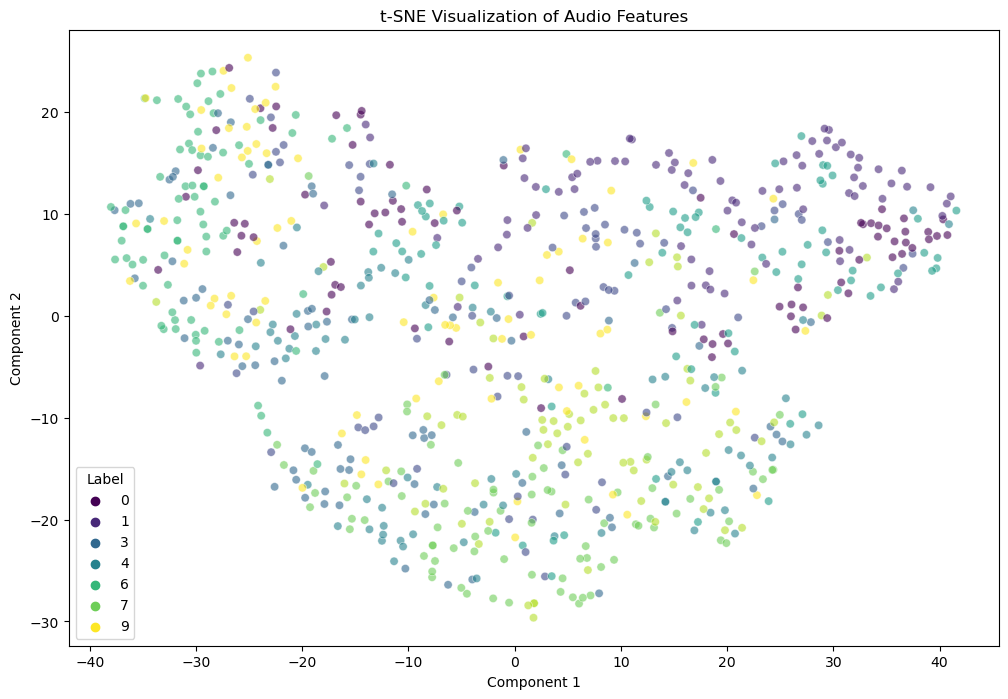

In [64]:
plot_tsne(train_features["global_max_pooling"], train_labels)

Trying longer recordings

In [366]:
DURATION = 10.0
N_MELS = 96

In [60]:
train_loader_96, val_loader_96, test_loader_96 = get_dataloaders(AUDIO_DIR, GENRES, batch_size=BATCH_SIZE, n_mels=N_MELS, shuffle=False)

dataset length 999


### Training

In [59]:
conv_rbm_96 = ConvRBM(
    visible_channels=VISIBLE_CHANNELS,
    hidden_channels=HIDDEN_CHANNELS,
    kernel_size=KERNEL_SIZE,
    learning_rate=LEARNING_RATE,
    cd_k=CD_K,
    batch_size=BATCH_SIZE  # Ensure batch size is passed
).to(DEVICE)


In [ ]:
conv_rbm_96.train_rbm(
    train_loader_96, 
    val_loader_96,
    epochs=1000, 
    device=DEVICE,
    save_interval=5)

In [ ]:
# Load the saved model weights
conv_rbm_96.load_state_dict(torch.load('./model_weights/rbm_epoch_140.pth'))
conv_rbm_96.eval()

# Initialize dictionaries for storing features
train_features = {}
test_features = {}

for approach in approaches:
    print(f"Processing features for approach: {approach}")
    # Initialize lists for storing features for the current approach
    train_batch = []
    test_batch = []

    with torch.no_grad():
        # Process training features
        for train_X, _ in train_loader_96:
            train_X = train_X.to(DEVICE)
            f = conv_rbm_96.transform(train_X, approach=approach)
            train_batch.append(f.cpu().numpy())

        # Store all training features as a single big list in the dictionary
        train_features[approach] = np.concatenate(train_batch, axis=0)

        # Process testing features
        for test_X, _ in test_loader_96:
            test_X = test_X.to(DEVICE)
            f = conv_rbm_96.transform(test_X, approach=approach)
            test_batch.append(f.cpu().numpy())

        # Store all testing features as a single big list in the dictionary
        test_features[approach] = np.concatenate(test_batch, axis=0)

# The train_features and test_features dictionaries now store features for each approach
# Each value is a single concatenated NumPy array

In [63]:
# random forest classifier
for approach in train_features.keys():
    # Train Decision Tree Classifier
    dt_clf = RandomForestClassifier(max_depth=15, random_state=13)
    print(len(train_features[approach]))
    dt_clf.fit(train_features[approach], train_labels)
    
    # Predict on the test set
    test_predictions = dt_clf.predict(test_features[approach])

    # Evaluate the classifier
    accuracy = accuracy_score(test_labels, test_predictions)
    print(f"Decision Tree Classifier Accuracy using {approach} pooling: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(test_labels, test_predictions))

799
Decision Tree Classifier Accuracy using flatten pooling: 0.4700

Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.50      0.47         8
           1       0.42      1.00      0.59         5
           2       0.67      0.36      0.47        11
           3       0.25      0.33      0.29         6
           4       0.38      0.27      0.32        11
           5       0.80      0.57      0.67        14
           6       0.80      0.71      0.75        17
           7       0.29      0.67      0.40         6
           8       0.33      0.25      0.29        12
           9       0.22      0.20      0.21        10

    accuracy                           0.47       100
   macro avg       0.46      0.49      0.44       100
weighted avg       0.51      0.47      0.47       100

799
Decision Tree Classifier Accuracy using global_average_pooling pooling: 0.3500

Classification Report:
              precision    recall  f1-scor

In [375]:
print("Train features shape:", train_features["flatten"].shape)

Train features shape: (799, 16)
